In [154]:
!pip install keras
!pip install tensorflow
!pip install arabic_reshaper
!pip install python-bidi
!pip install pad_sequences
!pip install keras_preprocessing

In [3]:
import os
import re
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from bidi.algorithm import get_display
from arabic_reshaper import arabic_reshaper
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from tensorflow.keras.preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences
from keras.backend import clear_session
from keras.models import Sequential
from keras import layers

In [4]:
pd.set_option('display.max_colwidth', None)

In [5]:
seed = 42

In [6]:
def clean_text(text):
    # ref: https://github.com/bakrianoo/aravec
    search = ["أ","إ","آ","ة","_","-","/",".","،"," و "," يا ",'"',"ـ","'","ى",
              "\\",'\n', '\t','&quot;','?','؟','!']
    replace = ["ا","ا","ا","ه"," "," ","","",""," و"," يا",
               "","","","ي","",' ', ' ',' ',' ? ',' ؟ ', ' ! ']

    tashkeel = re.compile(r'[\u0617-\u061A\u064B-\u0652]')
    text = re.sub(tashkeel,"", text)

    longation = re.compile(r'(.)\1+')
    subst = r"\1\1"
    text = re.sub(longation, subst, text)

    text = re.sub(r"[^\w\s]", '', text)
    text = re.sub(r"[a-zA-Z]", '', text)
    text = re.sub(r"\d+", ' ', text)
    text = re.sub(r"\n+", ' ', text)
    text = re.sub(r"\t+", ' ', text)
    text = re.sub(r"\r+", ' ', text)
    text = re.sub(r"\s+", ' ', text)
    text = text.replace('وو', 'و')
    text = text.replace('يي', 'ي')
    text = text.replace('اا', 'ا')

    for i in range(0, len(search)):
        text = text.replace(search[i], replace[i])

    text = text.strip()

    return text

In [55]:
data = pd.read_csv('Arabic_resturant_reviews.csv')
data.head()

,review,label
0,المطعم يجنن والاكل تحفة,1
1,أنصح بزيارة المطعم ده بجد، الأكل عندهم لذيذ والخدمة متميزة جداً.,1
2,لقد كانت تجربة سيئة، الطعام غير مقبول والخدمة سيئة للغاية.,-1
3,الطاقم غير احترافي على الإطلاق، والخدمة بطيئة وغير فعّالة.,-1
4,الطعام في هذا المطعم كان سيئًا للغاية والخدمة كانت سيئة أيضًا، لم يكن هناك أي اهتمام بتجربة العملاء.,-1


In [56]:
data.shape

(800, 2)

In [57]:
data = data[data.label.isin([-1, 1])]

In [58]:
data.shape

(800, 2)

In [59]:
data['cleaned_text'] = data.review.apply(clean_text)

In [60]:
data.shape

(800, 3)

In [61]:
data = data[data.cleaned_text != ""]
data.head(3)

,review,label,cleaned_text
0,المطعم يجنن والاكل تحفة,1,المطعم يجنن والاكل تحفه
1,أنصح بزيارة المطعم ده بجد، الأكل عندهم لذيذ والخدمة متميزة جداً.,1,انصح بزياره المطعم ده بجد الاكل عندهم لذيذ والخدمه متميزه جدا
2,لقد كانت تجربة سيئة، الطعام غير مقبول والخدمة سيئة للغاية.,-1,لقد كانت تجربه سيئه الطعام غير مقبول والخدمه سيئه للغايه


In [62]:
min_sample = data.groupby(['label']).count().review.min()
min_sample

400

In [79]:
input_data = pd.concat([data[data.label == 1].head(min_sample),
                        data[data.label == -1].head(min_sample)])
input_data

,review,label,cleaned_text
0,المطعم يجنن والاكل تحفة,1,المطعم يجنن والاكل تحفه
1,أنصح بزيارة المطعم ده بجد، الأكل عندهم لذيذ والخدمة متميزة جداً.,1,انصح بزياره المطعم ده بجد الاكل عندهم لذيذ والخدمه متميزه جدا
6,المطعم ده بيقدم أطباق لذيذة جداً والخدمة سريعة وممتازة، مكان مثالي للخروج.,1,المطعم ده بيقدم اطباق لذيذه جدا والخدمه سريعه وممتازه مكان مثالي للخروج
7,أفضل مطعم جربته بحياتي، الطعم له طعم ثاني.,1,افضل مطعم جربته بحياتي الطعم له طعم ثاني
10,المطعم ده بجد بيديك إحساس بالسعادة الكاملة، الأكل فيه بيديك شعور بالسلام الداخلي والراحة.,1,المطعم ده بجد بيديك احساس بالسعاده الكامله الاكل فيه بيديك شعور بالسلام الداخلي والراحه
...,...,...,...
791,الأكل كان زفت ومالح، مش هرجع تاني عشان أجرب.,-1,الاكل كان زفت ومالح مش هرجع تاني عشان اجرب
792,أسوأ تجربة مرت علي في المطاعم، الأكل غير صالح للأكل والخدمة زفت بمعنى الكلمة.,-1,اسوا تجربه مرت علي في المطاعم الاكل غير صالح للاكل والخدمه زفت بمعني الكلمه
793,تجربة سيئة جدًا في هذا المطعم، الطعام كان سيئًا للغاية وغير صالح للأكل، وكانت الخدمة بطيئة ولا يوجد أي اهتمام بتجربة الزبائن. لن أعود إلى هذا المطعم مرة أخرى بالتأكيد.,-1,تجربه سيئه جدا في هذا المطعم الطعام كان سيئا للغايه وغير صالح للاكل وكانت الخدمه بطيئه ولا يوجد اي اهتمام بتجربه الزبائن لن اعود الي هذا المطعم مره اخري بالتاكيد
796,كانت تجربتي في هذا المطعم فاشلة، الطعام كان سيئًا للغاية ولم يكن طازجًا على الإطلاق، وكانت الخدمة بطيئة وغير احترافية. لن أعود هنا مرة أخرى بالتأكيد.,-1,كانت تجربتي في هذا المطعم فاشله الطعام كان سيئا للغايه ولم يكن طازجا علي الاطلاق وكانت الخدمه بطيئه وغير احترافيه لن اعود هنا مره اخري بالتاكيد


In [80]:
input_data.groupby(['label']).count()

,review,cleaned_text
label,,
-1,400,400
1,400,400


In [81]:
X = input_data.cleaned_text.values

In [82]:
Y = np.asarray(input_data.label.values).astype('float32')
Y = Y.clip(0, 1)

In [83]:
num_words = 10000
tokenizer = Tokenizer(num_words=num_words)
tokenizer.fit_on_texts(X)

X = tokenizer.texts_to_sequences(X)

vocab_size = len(tokenizer.word_index) + 1
print("vocab size:", vocab_size)

vocab size: 1151


In [84]:
maxlen = 300
X = pad_sequences(X, padding='post', maxlen=maxlen)

In [85]:
with open('tokenizer.pkl', 'wb') as f:
    pickle.dump(tokenizer, f)

In [86]:
X_train, X_test, label_train, label_test = train_test_split(X, Y, test_size=0.3,
                                                            random_state=seed)

In [87]:
print("Training:", len(X_train), len(label_train))
print("Testing: ", len(X_test), len(label_test))

Training: 560 560
Testing:  240 240


In [88]:
embedding_dim = 100
dropout = 0.5
opt = 'adam'
clear_session()

model = Sequential()
model.add(layers.Embedding(input_dim=num_words,
                           output_dim=embedding_dim,
                           input_length=maxlen))
model.add(layers.Bidirectional(layers.LSTM(100, dropout=dropout,
                                           recurrent_dropout=dropout,
                                           return_sequences=True)))
model.add(layers.GlobalMaxPool1D())
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dropout(dropout))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dropout(dropout))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dropout(dropout))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer=opt,
              loss='binary_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 300, 100)          1000000   
                                                                 
 bidirectional (Bidirection  (None, 300, 200)          160800    
 al)                                                             
                                                                 
 global_max_pooling1d (Glob  (None, 200)               0         
 alMaxPooling1D)                                                 
                                                                 
 dense (Dense)               (None, 128)               25728     
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 64)                8

In [103]:
history = model.fit(X_train, label_train,
                    epochs=4,
                    verbose=True,
                    validation_data=(X_test, label_test),
                    batch_size=64)
loss, accuracy = model.evaluate(X_train, label_train, verbose=True)
print("Training Accuracy: {:.4f}".format(accuracy))
loss_val, accuracy_val = model.evaluate(X_test, label_test, verbose=True)
print("Testing Accuracy:  {:.4f}".format(accuracy_val))

Epoch 1/4
9/9 [==============================] - 16s 2s/step - loss: 0.6456 - accuracy: 0.6500 - val_loss: 0.5859 - val_accuracy: 0.8625
Epoch 2/4
9/9 [==============================] - 16s 2s/step - loss: 0.4709 - accuracy: 0.8321 - val_loss: 0.3589 - val_accuracy: 0.9333
Epoch 3/4
9/9 [==============================] - 15s 2s/step - loss: 0.2938 - accuracy: 0.9196 - val_loss: 0.2396 - val_accuracy: 0.9375
Epoch 4/4
18/18 [==============================] - 3s 167ms/step - loss: 0.1239 - accuracy: 0.9732
Training Accuracy: 0.9732
8/8 [==============================] - 1s 169ms/step - loss: 0.2821 - accuracy: 0.9292
Testing Accuracy:  0.9292


In [104]:
blind_sample = 200
blind_test = pd.concat([data[data.label == 1].tail(blind_sample),
                        data[data.label == -1].tail(blind_sample)])
blind_test

,review,label,cleaned_text
418,طعم الطعام في المطعم ده لا يُقاوم، كل لقمة فيها تجربة فريدة!,1,طعم الطعام في المطعم ده لا يقاوم كل لقمه فيها تجربه فريده
420,أجواء هادئة وأطعمة لذيذة، لقد كانت تجربة رائعة.,1,اجواء هادئه واطعمه لذيذه لقد كانت تجربه رائعه
421,الأكل في المطعم ده بيديك شعور بالرضا والسعادة، الجو فيه بيديك شعور بالسكينة والهدوء.,1,الاكل في المطعم ده بيديك شعور بالرضا والسعاده الجو فيه بيديك شعور بالسكينه والهدوء
422,تجربة الطعام في المطعم ده فوق الوصف، الأكل جامد والخدمة مظبوطة يعني.,1,تجربه الطعام في المطعم ده فوق الوصف الاكل جامد والخدمه مظبوطه يعني
423,طعام رائع وخدمة ممتازة، إنه المكان المثالي لتجربة تناول الطعام.,1,طعام رائع وخدمه ممتازه انه المكان المثالي لتجربه تناول الطعام
...,...,...,...
791,الأكل كان زفت ومالح، مش هرجع تاني عشان أجرب.,-1,الاكل كان زفت ومالح مش هرجع تاني عشان اجرب
792,أسوأ تجربة مرت علي في المطاعم، الأكل غير صالح للأكل والخدمة زفت بمعنى الكلمة.,-1,اسوا تجربه مرت علي في المطاعم الاكل غير صالح للاكل والخدمه زفت بمعني الكلمه
793,تجربة سيئة جدًا في هذا المطعم، الطعام كان سيئًا للغاية وغير صالح للأكل، وكانت الخدمة بطيئة ولا يوجد أي اهتمام بتجربة الزبائن. لن أعود إلى هذا المطعم مرة أخرى بالتأكيد.,-1,تجربه سيئه جدا في هذا المطعم الطعام كان سيئا للغايه وغير صالح للاكل وكانت الخدمه بطيئه ولا يوجد اي اهتمام بتجربه الزبائن لن اعود الي هذا المطعم مره اخري بالتاكيد
796,كانت تجربتي في هذا المطعم فاشلة، الطعام كان سيئًا للغاية ولم يكن طازجًا على الإطلاق، وكانت الخدمة بطيئة وغير احترافية. لن أعود هنا مرة أخرى بالتأكيد.,-1,كانت تجربتي في هذا المطعم فاشله الطعام كان سيئا للغايه ولم يكن طازجا علي الاطلاق وكانت الخدمه بطيئه وغير احترافيه لن اعود هنا مره اخري بالتاكيد


In [105]:
X_blind = blind_test.cleaned_text.values
Y_blind = np.asarray(blind_test.label.values).astype('float32')
Y_blind = Y_blind.clip(0, 1)

In [106]:
X_blind = tokenizer.texts_to_sequences(X_blind)
X_blind = pad_sequences(X_blind, padding='post', maxlen=maxlen)
X_blind

array([[ 57,   5,   7, ...,   0,   0,   0],
       [133, 329, 203, ...,   0,   0,   0],
       [  4,   7,   1, ...,   0,   0,   0],
       ...,
       [  8,  10,   2, ...,   0,   0,   0],
       [ 15,  86,   7, ...,   0,   0,   0],
       [ 54,  60,  71, ...,   0,   0,   0]], dtype=int32)

In [107]:
pred_blind = model.predict(X_blind, verbose=True)

13/13 [==============================] - 3s 195ms/step


In [112]:
df_blind = pd.DataFrame({'REAL': Y_blind,
                         'PRED': pred_blind.reshape(pred_blind.shape[0],),
                         'TEXT': blind_test.cleaned_text})
df_blind = df_blind.reset_index()[['REAL', 'PRED', 'TEXT']]
df_blind.PRED = df_blind.PRED.round()
error_records = df_blind[df_blind.REAL != df_blind.PRED]

In [113]:
print("Number of misclassified reviews: {} out of {}".format(error_records.shape[0], df_blind.shape[0]))
print("Blind Test Accuracy:  {:.4f}".format(accuracy_score(df_blind.REAL, df_blind.PRED)))

Number of misclassified reviews: 14 out of 400
Blind Test Accuracy:  0.9650


In [114]:
df_blind.sample(n=100)

,REAL,PRED,TEXT
82,1.0,1.0,خدمه استثنائيه واطباق لذيذه ساوصي بهذا المطعم للاصدقاء
49,1.0,1.0,اول مره ازور هالمطعم واندهشت من جوده الاكل يستاهل الزياره
54,1.0,1.0,طعام لذيذ واجواء رائعه انصح بزياره هذا المطعم بلا تردد
350,0.0,0.0,المطعم ده ما بيعطيك الا تجربه سيئه الاكل عندهم مش بطعمه والخدمه معدومه تماما
305,0.0,0.0,الطعام كان سيئا للغايه وكانت الاطباق بارده عندما وصلت
...,...,...,...
109,1.0,1.0,مطعم بيديك شعور انك في بيتك كل ما اروح له بحس اني بين اهلي
90,1.0,1.0,الاكل لذيذ والاسعار مناسبه مطعم ممتاز
380,0.0,0.0,هالمكان ما بيعطيك الا تجربه سيئه الاكل عندهم مش بطعمه والخدمه معدومه تماما
93,1.0,1.0,خدمه سريعه وديه والاطعمه طازجه ولذيذه


In [115]:
with open('model_acc{}.json'.format(round(accuracy_val, 4)), 'w') as f:
    f.write(model.to_json())
    f.close()

In [128]:
model.save('resturent_sentiment_analysis_arabic.h5'.format(round(accuracy_val, 4)))

In [138]:
import numpy as np
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.sequence import pad_sequences
import pickle

# Load tokenizer
with open('tokenizer.pkl', 'rb') as f:
    tokenizer = pickle.load(f)

# Load model
model = load_model('resturent_sentiment_analysis_arabic.h5')

# Maximum length for padding sequences
maxlen = 300

def preprocess_text(text):
    # Clean and preprocess the text
    cleaned_text = clean_text(text)
    tokenized_text = tokenizer.texts_to_sequences([cleaned_text])
    padded_text = pad_sequences(tokenized_text, padding='post', maxlen=maxlen)
    return padded_text

def classify_text(text):
    # Preprocess text
    preprocessed_text = preprocess_text(text)

    # Predict sentiment
    prediction = model.predict(preprocessed_text)
    sentiment = "Positive" if prediction > 0.5 else "Negative"

    return sentiment

if __name__ == "__main__":
    # Input text
    text = input("Enter the text to classify: ")

    # Classify text
    result = classify_text(text)
    print(f"The sentiment of the text is: {result}")


Enter the text to classify: مطعم زي الفل وعشره علي عشره
1/1 [==============================] - 1s 967ms/step
The sentiment of the text is: Positive


In [139]:
from joblib import dump

# Save tokenizer
dump(tokenizer, 'tokenizer.joblib')

['tokenizer.joblib']

In [140]:
    # Input text
    text = input("Enter the text to classify: ")

    # Classify text
    result = classify_text(text)
    print(f"The sentiment of the text is: {result}")

Enter the text to classify: الاكل حلو اوي ويستاهل السعر والمكان نضيف ومنظم
1/1 [==============================] - 0s 94ms/step
The sentiment of the text is: Positive


<ipython-input-150-0cab3913c98d>:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=class_distribution.index, y=class_distribution.values, palette=["#1f77b4", "#d62728"])


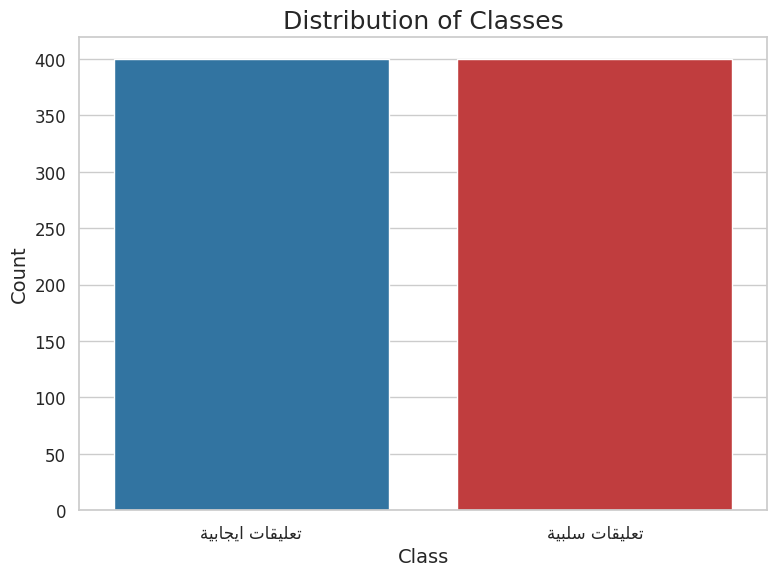

In [150]:
positive = get_display(arabic_reshaper.reshape('تعليقات ايجابية'))
negative = get_display(arabic_reshaper.reshape('تعليقات سلبية'))

# Your class distribution data
class_distribution = data['label'].value_counts()

# Define mapping from numerical labels to Arabic strings
label_mapping = {1: positive, -1: negative}

# Map numerical labels to Arabic strings
class_distribution.index = class_distribution.index.map(label_mapping)

# Set seaborn style
sns.set(style="whitegrid", font_scale=1.2)

# Plotting
plt.figure(figsize=(8, 6))  # Adjust figure size as needed
sns.barplot(x=class_distribution.index, y=class_distribution.values, palette=["#1f77b4", "#d62728"])
plt.title('Distribution of Classes', fontsize=18)
plt.xlabel('Class', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.xticks(fontsize=12)  # Adjust x-axis tick font size
plt.yticks(fontsize=12)  # Adjust y-axis tick font size
plt.tight_layout()  # Adjust layout to prevent clipping of labels
plt.show()

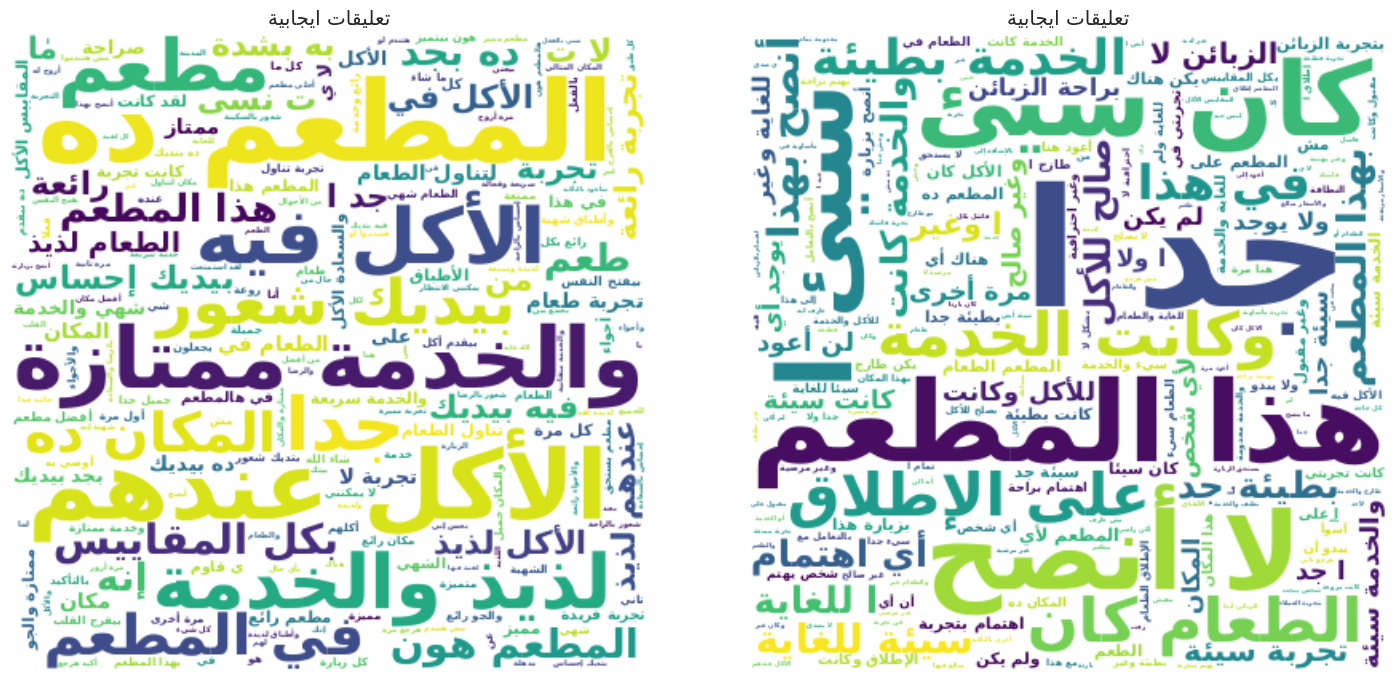

In [153]:
from wordcloud import WordCloud
classes = data['label'].unique()
fig, axs = plt.subplots(1, len(classes), figsize=(15, 7))

for i, label in enumerate(classes):
    # Filter reviews based on class label
    reviews = ' '.join(data[data['label'] == label]['review'])

    # Generate word cloud
    wordcloud = WordCloud(font_path='DejaVuSans-Bold.ttf',
                          background_color='white',
                          width=400,
                          height=400,
                          max_words=200,
                          contour_color='steelblue').generate(reviews)

    # Display the word cloud
    axs[i].imshow(wordcloud, interpolation='bilinear')
    title = negative if label == 0 else positive
    axs[i].set_title(title)
    axs[i].axis('off')

plt.tight_layout()
plt.show()

In [155]:
    # Input text
    text = input("Enter the text to classify: ")

    # Classify text
    result = classify_text(text)
    print(f"The sentiment of the text is: {result}")

Enter the text to classify: المكان وحش اوي والاكل مالح والخدمه مش حلوه خالص
1/1 [==============================] - 0s 162ms/step
The sentiment of the text is: Negative


In [156]:
    # Input text
text = input("Enter the text to classify: ")

    # Classify text
result = classify_text(text)
print(f"The sentiment of the text is: {result}")

Enter the text to classify: الاكل سيء جدا والنظافة مش احسن حاجه
1/1 [==============================] - 0s 93ms/step
The sentiment of the text is: Negative


In [157]:
    # Input text
text = input("Enter the text to classify: ")

    # Classify text
result = classify_text(text)
print(f"The sentiment of the text is: {result}")

Enter the text to classify: الاكل تحفة والمكان اروع ما يمكن
1/1 [==============================] - 0s 184ms/step
The sentiment of the text is: Positive


In [158]:
    # Input text
text = input("Enter the text to classify: ")

    # Classify text
result = classify_text(text)
print(f"The sentiment of the text is: {result}")

Enter the text to classify: الاكل جامد اوي والمطعم علي فيو حكايه
1/1 [==============================] - 0s 177ms/step
The sentiment of the text is: Positive
